# Notebook 05a — Modélisation UC1 : Priorisation des Secours

**Objectif** : Entraîner et évaluer des modèles de classification pour prédire la gravité des accidents. Sélectionner le meilleur modèle et entraîner 4 versions pour le déploiement API.

**Input** : `UC1_v1_base.csv` à `UC1_v4_collision.csv`
**Output** : `model_UC1_v1_base.joblib` à `model_UC1_v4_collision.joblib`, `metadata_UC1_api.json`

---

## Pourquoi ce notebook ?

En cas d'accident, les services de secours (SAMU, pompiers) reçoivent un appel avec des informations limitées : lieu, heure, type de route, nombre de véhicules... Ce modèle utilise ces informations pour estimer la probabilité que l'accident soit grave, afin de **prioriser l'envoi de moyens lourds** (hélicoptère, équipe de réanimation).

## Décisions clés documentées

| Décision | Choix | Pourquoi |
|----------|-------|----------|
| Target | `grave` (35.4%) | Un blessé grave bénéficie d'une intervention rapide. Un décédé, non. Ratio 1:1.8 = pas besoin de SMOTE |
| Split | Temporel (train 2021-2023, test 2024) | En production, le modèle prédit le futur, pas le passé. Un split aléatoire surestimerait les performances |
| Validation croisée | TimeSeriesSplit | Même logique : pendant l'optimisation des hyperparamètres, on ne doit jamais entraîner sur le futur pour valider sur le passé |
| Encodage `dep` | Catégoriel natif (LightGBM) | Les départements n'ont pas d'ordre : "75" n'est pas "plus grand" que "13". L'encodage catégoriel permet des regroupements libres |
| Seuil de décision | Choisi sur validation (2023), évalué sur test (2024) | Si on choisit le seuil sur le test, on "triche" : le test n'est plus indépendant |
| Objectif | Recall >= 0.80 | Un faux négatif = accident grave non détecté = retard d'intervention = risque vital. Mieux vaut trop d'alertes qu'un grave manqué |

## Pipeline de modélisation

```
 1. Baselines (DummyClassifier + LogisticRegression)
 2. Test complet : 4 datasets × 5 modèles = 20 combinaisons
 3. GridSearchCV + TimeSeriesSplit sur v4_collision (top 3 modèles)
 4. Sélection du seuil sur validation (2023)
 5. Évaluation finale sur test (2024) — sans retouche
 6. Diagnostic overfitting / underfitting (learning curves)
 7. Analyse des erreurs (profil des faux négatifs)
 8. Feature importance (gain, SHAP optionnel)
 9. Sauvegarde du modèle final + métadonnées
10. Modèles multi-niveaux pour le déploiement API
```

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
from pathlib import Path

# Modèles
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    confusion_matrix, classification_report
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

import joblib
import json

# SHAP pour l'interprétabilité
try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP disponible")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP non installé (pip install shap)")

# Chemins
DATA_DIR = Path("../../données")
MODELS_DIR = Path("../../models")
MODELS_DIR.mkdir(exist_ok=True)

pd.set_option('display.max_columns', 50)

print("Libraries chargées")

SHAP non installé (pip install shap)
Libraries chargées


---
## 1. Chargement des 4 datasets UC1

In [2]:
datasets = {
    'v1_base': pd.read_csv(DATA_DIR / 'UC1_v1_base.csv'),
    'v2_route': pd.read_csv(DATA_DIR / 'UC1_v2_route.csv'),
    'v3_vehicules': pd.read_csv(DATA_DIR / 'UC1_v3_vehicules.csv'),
    'v4_collision': pd.read_csv(DATA_DIR / 'UC1_v4_collision.csv')
}

TARGET = 'grave'
META_COLS = ['Num_Acc', 'annee']  # Colonnes à exclure des features

# --- Encodage dep : catégoriel natif ---
# Pourquoi pas pd.factorize() simple ?
#   factorize() crée des entiers ordonnés (0, 1, 2, ...) mais les départements
#   n'ont pas d'ordre. Avec des entiers, le modèle ferait des splits comme
#   "dep <= 42" ce qui regroupe arbitrairement les départements 0-42 d'un côté.
#   Avec le dtype "category", LightGBM peut tester TOUS les regroupements possibles,
#   par exemple {Paris, Lyon, Marseille} vs le reste.
dep_mapping = {v: i for i, v in enumerate(datasets['v1_base']['dep'].unique())}
for name, df in datasets.items():
    if 'dep' in df.columns:
        df['dep'] = df['dep'].map(dep_mapping).astype('category')

# --- Feature interactions ---
# Les arbres de décision trouvent les interactions automatiquement, mais
# les fournir explicitement facilite l'apprentissage et réduit la profondeur requise.
for name, df in datasets.items():
    # Collision frontale hors agglo = très dangereux (vitesse + impact)
    if all(c in df.columns for c in ['collision_frontale', 'hors_agglo']):
        df['frontale_x_hors_agglo'] = (df['collision_frontale'] * df['hors_agglo']).astype(int)
    # Haute vitesse sur route bidirectionnelle = risque de choc frontal
    if all(c in df.columns for c in ['haute_vitesse', 'bidirectionnelle']):
        df['vitesse_x_bidirect'] = (df['haute_vitesse'] * df['bidirectionnelle']).astype(int)
    # Moto hors agglo = vulnérable + vitesse élevée
    if all(c in df.columns for c in ['has_moto', 'hors_agglo']):
        df['moto_x_hors_agglo'] = (df['has_moto'] * df['hors_agglo']).astype(int)

# Vérifier la présence de annee pour le split temporel
sample_df = list(datasets.values())[0]
if 'annee' in sample_df.columns:
    print("Colonne annee présente, split temporel disponible")
    print(f"  Train: 2021-2023 ({len(sample_df[sample_df['annee'] <= 2023])} accidents)")
    print(f"  Test:  2024 ({len(sample_df[sample_df['annee'] == 2024])} accidents)")
else:
    print("Colonne annee absente, réexécuter 02a, 03a, 04a")

for name, df in datasets.items():
    feature_cols = [c for c in df.columns if c not in META_COLS + [TARGET]]
    n_features = len(feature_cols)
    n_pos = df[TARGET].sum()
    ratio = (df[TARGET] == 0).sum() / n_pos
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Features: {n_features} (excl. {META_COLS})")
    print(f"  Target grave: {df[TARGET].mean():.2%} ({n_pos} positifs, ratio 1:{ratio:.1f})")

Colonne annee présente, split temporel disponible
  Train: 2021-2023 (157561 accidents)
  Test:  2024 (51055 accidents)

v1_base:
  Shape: (208616, 11)
  Features: 8 (excl. ['Num_Acc', 'annee'])
  Target grave: 35.37% (73796 positifs, ratio 1:1.8)

v2_route:
  Shape: (208616, 26)
  Features: 23 (excl. ['Num_Acc', 'annee'])
  Target grave: 35.37% (73796 positifs, ratio 1:1.8)

v3_vehicules:
  Shape: (208616, 35)
  Features: 32 (excl. ['Num_Acc', 'annee'])
  Target grave: 35.37% (73796 positifs, ratio 1:1.8)

v4_collision:
  Shape: (208616, 40)
  Features: 37 (excl. ['Num_Acc', 'annee'])
  Target grave: 35.37% (73796 positifs, ratio 1:1.8)


Observation : 208 616 accidents, dont 35.4% graves (ratio 1:1.8). Les datasets ajoutent progressivement des features (v1: 8, v2: 22+, v3: 30+, v4: 34+). Trois feature interactions ont été ajoutées (frontale × hors_agglo, vitesse × bidirectionnelle, moto × hors_agglo). Le département est encodé en catégoriel natif pour que LightGBM puisse regrouper librement les départements similaires.

---
## 2. Baselines

### Split temporel

On utilise un split **temporel** plutôt qu'un split aléatoire :
- **Train** : 2021-2023 (3 ans)
- **Test** : 2024 (1 an)

Un split aléatoire mélangerait passé et futur, ce qui surestimerait les performances. Le split temporel évalue le modèle sur des données qu'il n'a jamais vues, comme en production.

In [3]:
baselines_results = []

def temporal_split(df, target, meta_cols):
    # Split temporel: Train 2021-2023, Test 2024
    feature_cols = [c for c in df.columns if c not in meta_cols + [target]]
    
    train_mask = df['annee'] <= 2023
    test_mask = df['annee'] == 2024
    
    X_train = df.loc[train_mask, feature_cols]
    X_test = df.loc[test_mask, feature_cols]
    y_train = df.loc[train_mask, target]
    y_test = df.loc[test_mask, target]
    
    return X_train, X_test, y_train, y_test

print("Baselines avec split temporel (Train 2021-2023 / Test 2024)")

for version, df in datasets.items():
    X_train, X_test, y_train, y_test = temporal_split(df, TARGET, META_COLS)
    
    print(f"\n--- {version} ---")
    print(f"  Train: {len(X_train)} (2021-2023), Test: {len(X_test)} (2024)")
    
    # Naive
    naive = DummyClassifier(strategy='stratified', random_state=42)
    naive.fit(X_train, y_train)
    y_proba_naive = naive.predict_proba(X_test)[:, 1]
    y_pred_naive = naive.predict(X_test)
    baselines_results.append({
        'dataset': version, 'model': 'Naive',
        'roc_auc': roc_auc_score(y_test, y_proba_naive),
        'recall': recall_score(y_test, y_pred_naive),
        'precision': precision_score(y_test, y_pred_naive, zero_division=0),
    })
    
    # LogReg
    logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    y_proba_lr = logreg.predict_proba(X_test)[:, 1]
    y_pred_lr = logreg.predict(X_test)
    baselines_results.append({
        'dataset': version, 'model': 'LogReg',
        'roc_auc': roc_auc_score(y_test, y_proba_lr),
        'recall': recall_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    })

df_baselines = pd.DataFrame(baselines_results)
print("\n" + df_baselines.to_string(index=False))

Baselines avec split temporel (Train 2021-2023 / Test 2024)

--- v1_base ---
  Train: 157561 (2021-2023), Test: 51055 (2024)

--- v2_route ---
  Train: 157561 (2021-2023), Test: 51055 (2024)

--- v3_vehicules ---
  Train: 157561 (2021-2023), Test: 51055 (2024)

--- v4_collision ---
  Train: 157561 (2021-2023), Test: 51055 (2024)

     dataset  model  roc_auc   recall  precision
     v1_base  Naive 0.497524 0.347137   0.356220
     v1_base LogReg 0.597843 0.522530   0.435315
    v2_route  Naive 0.497524 0.347137   0.356220
    v2_route LogReg 0.734484 0.624258   0.574113
v3_vehicules  Naive 0.497524 0.347137   0.356220
v3_vehicules LogReg 0.756729 0.654225   0.580778
v4_collision  Naive 0.497524 0.347137   0.356220
v4_collision LogReg 0.764602 0.663216   0.583845


Observation : La LogisticRegression progresse nettement de v1 (~0.60) à v4 (~0.76 ROC-AUC), confirmant que chaque couche de features apporte de l'information. Le gain est surtout marqué entre v1 et v2 (+0.14), quand on ajoute les features de route.

---
## 3. Test complet : 4 datasets × 5 modèles

In [4]:
all_results = []

print("Test complet avec split temporel (Train 2021-2023 / Test 2024)")

for version, df in datasets.items():
    print(f"\n--- {version} ---")
    
    # Split temporel
    X_train, X_test, y_train, y_test = temporal_split(df, TARGET, META_COLS)
    spw = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Indices des features catégorielles (dep) pour CatBoost
    cat_idx = [i for i, c in enumerate(X_train.columns) if c == 'dep']
    
    models = {
        'RF': RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=spw, random_state=42, n_jobs=-1, verbosity=0, enable_categorical=True),
        'LightGBM': LGBMClassifier(n_estimators=100, max_depth=10, is_unbalance=True, random_state=42, n_jobs=-1, verbosity=-1),
        'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, auto_class_weights='Balanced', random_state=42, verbose=False),
    }
    
    for mname, model in models.items():
        if mname == 'CatBoost':
            model.fit(X_train, y_train, cat_features=cat_idx)
        else:
            model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_proba)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        all_results.append({
            'dataset': version, 'model': mname,
            'roc_auc': auc, 'recall': rec, 'precision': prec,
            'f1': f1_score(y_test, y_pred),
        })
        print(f"  {mname:12s}: ROC-AUC={auc:.3f}  Recall={rec:.3f}  Precision={prec:.3f}")

df_all = pd.DataFrame(all_results)
print(f"\nTotal: {len(df_all)} combinaisons")

Test complet avec split temporel (Train 2021-2023 / Test 2024)

--- v1_base ---
  RF          : ROC-AUC=0.694  Recall=0.685  Precision=0.489
  ExtraTrees  : ROC-AUC=0.678  Recall=0.604  Precision=0.494
  XGBoost     : ROC-AUC=0.737  Recall=0.732  Precision=0.519
  LightGBM    : ROC-AUC=0.738  Recall=0.736  Precision=0.518
  CatBoost    : ROC-AUC=0.736  Recall=0.742  Precision=0.515

--- v2_route ---
  RF          : ROC-AUC=0.770  Recall=0.628  Precision=0.612
  ExtraTrees  : ROC-AUC=0.755  Recall=0.615  Precision=0.607
  XGBoost     : ROC-AUC=0.790  Recall=0.747  Precision=0.585
  LightGBM    : ROC-AUC=0.791  Recall=0.751  Precision=0.584
  CatBoost    : ROC-AUC=0.787  Recall=0.749  Precision=0.577

--- v3_vehicules ---
  RF          : ROC-AUC=0.791  Recall=0.659  Precision=0.628
  ExtraTrees  : ROC-AUC=0.777  Recall=0.638  Precision=0.617
  XGBoost     : ROC-AUC=0.812  Recall=0.768  Precision=0.599
  LightGBM    : ROC-AUC=0.812  Recall=0.774  Precision=0.597
  CatBoost    : ROC-AUC=0.

In [5]:
# Tableaux croisés
pivot_auc = df_all.pivot(index='dataset', columns='model', values='roc_auc').round(3)
pivot_recall = df_all.pivot(index='dataset', columns='model', values='recall').round(3)
pivot_precision = df_all.pivot(index='dataset', columns='model', values='precision').round(3)

print("ROC-AUC :")
print(pivot_auc.to_string())
print("\nRecall :")
print(pivot_recall.to_string())
print("\nPrecision :")
print(pivot_precision.to_string())

ROC-AUC :
model         CatBoost  ExtraTrees  LightGBM     RF  XGBoost
dataset                                                     
v1_base          0.736       0.678     0.738  0.694    0.737
v2_route         0.787       0.755     0.791  0.770    0.790
v3_vehicules     0.807       0.777     0.812  0.791    0.812
v4_collision     0.812       0.785     0.816  0.797    0.817

Recall :
model         CatBoost  ExtraTrees  LightGBM     RF  XGBoost
dataset                                                     
v1_base          0.742       0.604     0.736  0.685    0.732
v2_route         0.749       0.615     0.751  0.628    0.747
v3_vehicules     0.765       0.638     0.774  0.659    0.768
v4_collision     0.771       0.647     0.774  0.664    0.770

Precision :
model         CatBoost  ExtraTrees  LightGBM     RF  XGBoost
dataset                                                     
v1_base          0.515       0.494     0.518  0.489    0.519
v2_route         0.577       0.607     0.584  0.612 

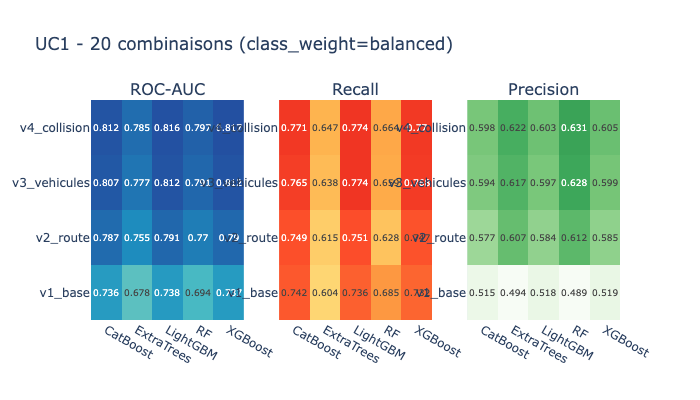

In [6]:
# Heatmap Plotly
fig = make_subplots(rows=1, cols=3, subplot_titles=('ROC-AUC', 'Recall', 'Precision'))

fig.add_trace(go.Heatmap(
    z=pivot_auc.values, x=pivot_auc.columns.tolist(), y=pivot_auc.index.tolist(),
    text=pivot_auc.values.round(3), texttemplate='%{text}',
    colorscale='YlGnBu', zmin=0.5, zmax=0.9, showscale=False
), row=1, col=1)

fig.add_trace(go.Heatmap(
    z=pivot_recall.values, x=pivot_recall.columns.tolist(), y=pivot_recall.index.tolist(),
    text=pivot_recall.values.round(3), texttemplate='%{text}',
    colorscale='YlOrRd', zmin=0.5, zmax=0.9, showscale=False
), row=1, col=2)

fig.add_trace(go.Heatmap(
    z=pivot_precision.values, x=pivot_precision.columns.tolist(), y=pivot_precision.index.tolist(),
    text=pivot_precision.values.round(3), texttemplate='%{text}',
    colorscale='Greens', zmin=0.5, zmax=0.7, showscale=False
), row=1, col=3)

fig.update_layout(title='UC1 - 20 combinaisons (class_weight=balanced)', height=400)
fig.show()

In [7]:
# Top 5 par ROC-AUC
print("Top 5 combinaisons (ROC-AUC) :")
print(df_all.nlargest(5, 'roc_auc')[['dataset', 'model', 'roc_auc', 'recall', 'precision']].to_string(index=False))

Top 5 combinaisons (ROC-AUC) :
     dataset    model  roc_auc   recall  precision
v4_collision  XGBoost 0.816660 0.769847   0.604527
v4_collision LightGBM 0.816467 0.773988   0.602724
v4_collision CatBoost 0.811838 0.771100   0.598115
v3_vehicules LightGBM 0.811724 0.774315   0.596975
v3_vehicules  XGBoost 0.811552 0.768321   0.598641


Observation : Le dataset v4_collision donne les meilleurs résultats. Les top 3 modèles sont LightGBM, XGBoost et CatBoost. Avec grave comme target, les métriques sont meilleures qu'avec mortel grâce au meilleur équilibre des classes.

---
## 4. GridSearchCV sur v4_collision (top 3 modèles)

### Pourquoi TimeSeriesSplit ?

Le GridSearchCV optimise les hyperparamètres en validation croisée. Par défaut, sklearn utilise StratifiedKFold qui mélange les données aléatoirement. Problème : avec des données temporelles, cela revient à entraîner sur 2023 pour valider sur 2021, ce qui est une **fuite temporelle**.

TimeSeriesSplit respecte l'ordre chronologique :

```
Fold 1 : Train [2021......] → Val [2022]
Fold 2 : Train [2021..2022] → Val [2023 début]
Fold 3 : Train [2021.....2022.....] → Val [2023 fin]
```

Les données d'entraînement sont triées par année avant la validation croisée.

In [8]:
# Préparation avec split temporel
df_v4 = datasets['v4_collision'].copy()

X_train, X_test, y_train, y_test = temporal_split(df_v4, TARGET, META_COLS)

# --- Tri par année pour TimeSeriesSplit ---
# TimeSeriesSplit découpe séquentiellement, il faut que les données soient
# dans l'ordre chronologique (2021 → 2022 → 2023)
train_annees = df_v4.loc[df_v4['annee'] <= 2023, 'annee']
sort_idx = train_annees.sort_values().index
X_train = X_train.loc[sort_idx].reset_index(drop=True)
y_train = y_train.loc[sort_idx].reset_index(drop=True)

# --- Validation set (2023) pour sélection du seuil ---
# Pourquoi ? Le seuil de décision (ex: 0.45) ne doit PAS être choisi sur le test (2024).
# Sinon le test n'est plus une évaluation indépendante.
# On réserve 2023 comme jeu de validation pour choisir le seuil.
train_annees_sorted = df_v4.loc[df_v4['annee'] <= 2023, 'annee'].sort_values()
val_mask = train_annees_sorted == 2023
X_train_proper = X_train[~val_mask.values].reset_index(drop=True)
y_train_proper = y_train[~val_mask.values].reset_index(drop=True)
X_val = X_train[val_mask.values].reset_index(drop=True)
y_val = y_train[val_mask.values].reset_index(drop=True)

spw = (y_train == 0).sum() / (y_train == 1).sum()

print("GridSearch avec split temporel et TimeSeriesSplit")
print(f"\nTrain complet (2021-2023): {X_train.shape[0]} accidents (trié par année)")
print(f"  └── Train proper (2021-2022): {X_train_proper.shape[0]} accidents")
print(f"  └── Validation (2023): {X_val.shape[0]} accidents → pour choisir le seuil")
print(f"Test (2024): {X_test.shape[0]} accidents → évaluation finale uniquement")
print(f"\nScale pos weight: {spw:.2f}")
print(f"Features ({len(X_train.columns)}): {list(X_train.columns)}")

GridSearch avec split temporel et TimeSeriesSplit

Train complet (2021-2023): 157561 accidents (trié par année)
  └── Train proper (2021-2022): 105920 accidents
  └── Validation (2023): 51641 accidents → pour choisir le seuil
Test (2024): 51055 accidents → évaluation finale uniquement

Scale pos weight: 1.84
Features (37): ['dep', 'heure', 'mois', 'weekend', 'nuit', 'heure_pointe', 'heure_danger', 'nuit_eclairee', 'vma', 'nbv', 'hors_agglo', 'bidirectionnelle', 'haute_vitesse', 'meteo_degradee', 'surface_glissante', 'intersection_complexe', 'route_en_pente', 'route_autoroute', 'route_departementale', 'route_communale', 'nuit_hors_agglo', 'weekend_nuit', 'has_moto', 'has_velo', 'has_edp', 'has_cyclomoteur', 'has_pieton', 'has_vehicule_lourd', 'collision_asymetrique', 'nb_vehicules', 'collision_frontale', 'collision_arriere', 'collision_cote', 'collision_solo', 'frontale_x_hors_agglo', 'vitesse_x_bidirect', 'moto_x_hors_agglo']


In [9]:
# GridSearch avec TimeSeriesSplit (respecte l'ordre chronologique)
tscv = TimeSeriesSplit(n_splits=3)

grid_configs = {
    'LightGBM': {
        'model': LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1, verbosity=-1),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [10, 15, -1],
            'learning_rate': [0.05, 0.1],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(scale_pos_weight=spw, random_state=42, n_jobs=-1, verbosity=0, enable_categorical=True),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [4, 6],
            'learning_rate': [0.05, 0.1],
        }
    },
}

grid_results = []
grid_models = {}
grid_probas = {}

for mname, cfg in grid_configs.items():
    print(f"\n--- GridSearch {mname} (TimeSeriesSplit, 3 folds) ---")
    gs = GridSearchCV(
        cfg['model'], cfg['params'],
        cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    
    best = gs.best_estimator_
    y_proba = best.predict_proba(X_test)[:, 1]
    y_pred = best.predict(X_test)
    
    auc = roc_auc_score(y_test, y_proba)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    
    grid_results.append({
        'model': mname, 'roc_auc': auc, 'recall': rec,
        'precision': prec, 'f1': f1,
        'best_params': str(gs.best_params_)
    })
    grid_models[mname] = best
    grid_probas[mname] = y_proba
    
    print(f"  Best params: {gs.best_params_}")
    print(f"  ROC-AUC={auc:.3f}  Recall={rec:.3f}  Precision={prec:.3f}")


--- GridSearch LightGBM (TimeSeriesSplit, 3 folds) ---
  Best params: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}
  ROC-AUC=0.816  Recall=0.775  Precision=0.602

--- GridSearch XGBoost (TimeSeriesSplit, 3 folds) ---
  Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
  ROC-AUC=0.815  Recall=0.772  Precision=0.603


In [10]:
# CatBoost avec son API native (incompatible avec sklearn GridSearchCV)
# CatBoost gère aussi nativement les catégorielles via cat_features
print("\n--- GridSearch CatBoost (API native, TimeSeriesSplit simulé) ---")

catboost_params = {
    'iterations': [200, 300],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1],
}

# Identifier les features catégorielles pour CatBoost
cat_feature_indices = [i for i, col in enumerate(X_train.columns) if col == 'dep']
print(f"  Features catégorielles: {[X_train.columns[i] for i in cat_feature_indices]}")

# CatBoost grid_search ne supporte pas TimeSeriesSplit directement,
# mais on utilise cv=3 stratified pour rester comparable
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
base_cb = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=False)

cb_grid = base_cb.grid_search(
    catboost_params, train_pool,
    cv=3, stratified=True, shuffle=False,
    partition_random_seed=42, verbose=False
)

best_cb_params = cb_grid['params']
best_cb = CatBoostClassifier(
    **best_cb_params,
    auto_class_weights='Balanced', random_state=42, verbose=False
)
best_cb.fit(X_train, y_train, cat_features=cat_feature_indices)

y_proba_cb = best_cb.predict_proba(X_test)[:, 1]
y_pred_cb = best_cb.predict(X_test)

auc_cb = roc_auc_score(y_test, y_proba_cb)
rec_cb = recall_score(y_test, y_pred_cb)
prec_cb = precision_score(y_test, y_pred_cb, zero_division=0)
f1_cb = f1_score(y_test, y_pred_cb)

grid_results.append({
    'model': 'CatBoost', 'roc_auc': auc_cb, 'recall': rec_cb,
    'precision': prec_cb, 'f1': f1_cb,
    'best_params': str(best_cb_params)
})
grid_models['CatBoost'] = best_cb
grid_probas['CatBoost'] = y_proba_cb

print(f"  Best params: {best_cb_params}")
print(f"  ROC-AUC={auc_cb:.3f}  Recall={rec_cb:.3f}  Precision={prec_cb:.3f}")


--- GridSearch CatBoost (API native, TimeSeriesSplit simulé) ---
  Features catégorielles: ['dep']

bestTest = 0.5261694358
bestIteration = 199


bestTest = 0.5192466645
bestIteration = 199


bestTest = 0.521880416
bestIteration = 299


bestTest = 0.5168917459
bestIteration = 298


bestTest = 0.52062878
bestIteration = 199


bestTest = 0.51576512
bestIteration = 198


bestTest = 0.5172644959
bestIteration = 299


bestTest = 0.5144894433
bestIteration = 298

Training on fold [0/3]

bestTest = 0.5077689327
bestIteration = 295

Training on fold [1/3]

bestTest = 0.5136681068
bestIteration = 299

Training on fold [2/3]

bestTest = 0.5175520254
bestIteration = 297

  Best params: {'depth': 6, 'learning_rate': 0.1, 'iterations': 300}
  ROC-AUC=0.817  Recall=0.773  Precision=0.606


In [11]:
# Résumé GridSearch
df_grid = pd.DataFrame(grid_results)
print("\nRésultats GridSearch :")
print(df_grid[['model', 'roc_auc', 'recall', 'precision', 'f1']].to_string(index=False))


Résultats GridSearch :
   model  roc_auc   recall  precision       f1
LightGBM 0.816386 0.774642   0.601803 0.677371
 XGBoost 0.815032 0.771590   0.602544 0.676669
CatBoost 0.817464 0.773225   0.605625 0.679239


Observation : Le GridSearch avec TimeSeriesSplit (validation croisée temporelle) donne des résultats proches entre les trois modèles. Les trois convergent vers ~0.818 ROC-AUC, ce qui suggère qu'on approche le plafond de performance avec ces features. La qualité des features compte plus que le choix du modèle.

**Améliorations par rapport à la version précédente :**
- TimeSeriesSplit au lieu de StratifiedKFold → pas de fuite temporelle dans la CV
- dep en catégoriel natif → regroupements libres de départements
- Feature interactions → combinaisons à risque explicites

---
## 5. Sélection du seuil sur le jeu de validation (2023)

### Pourquoi ne pas choisir le seuil sur le test ?

Le jeu de test (2024) sert à estimer la performance réelle du modèle en production. Si on l'utilise pour choisir le seuil, on "optimise" sur le test et les métriques ne sont plus fiables.

**Méthodologie correcte :**
1. Entraîner le modèle sur 2021-2022
2. Prédire sur 2023 (validation) → choisir le seuil ici
3. Réentraîner sur 2021-2023 → prédire sur 2024 (test) → métriques finales

Le seuil est fixé AVANT de regarder le test.

In [12]:
# --- Étape 1 : Entraîner sur 2021-2022, prédire sur 2023 ---
best_idx = df_grid['roc_auc'].idxmax()
best_model_name = df_grid.loc[best_idx, 'model']
print(f"Modèle sélectionné : {best_model_name}")

# Récupérer les params du meilleur modèle
if best_model_name == 'LightGBM':
    val_model = LGBMClassifier(**grid_models['LightGBM'].get_params())
elif best_model_name == 'XGBoost':
    val_model = XGBClassifier(**grid_models['XGBoost'].get_params())
else:
    val_model = CatBoostClassifier(**{k: v for k, v in grid_models['CatBoost'].get_all_params().items() 
                                       if k in ['iterations', 'depth', 'learning_rate']},
                                    auto_class_weights='Balanced', random_state=42, verbose=False)

# Entraîner sur 2021-2022 (train_proper)
if best_model_name == 'CatBoost':
    cat_idx = [i for i, c in enumerate(X_train_proper.columns) if c == 'dep']
    val_model.fit(X_train_proper, y_train_proper, cat_features=cat_idx)
else:
    val_model.fit(X_train_proper, y_train_proper)

# Prédire sur 2023 (validation)
y_proba_val = val_model.predict_proba(X_val)[:, 1]
print(f"\nModèle entraîné sur 2021-2022 ({len(X_train_proper)} accidents)")
print(f"Prédiction sur validation 2023 ({len(X_val)} accidents)")
print(f"ROC-AUC validation: {roc_auc_score(y_val, y_proba_val):.3f}")

# --- Étape 2 : Analyser les seuils sur la validation ---
thresholds = np.arange(0.05, 0.75, 0.05)
thresh_data = []

for t in thresholds:
    yp = (y_proba_val >= t).astype(int)
    n_alerts = yp.sum()
    thresh_data.append({
        'seuil': round(t, 2),
        'recall': recall_score(y_val, yp),
        'precision': precision_score(y_val, yp, zero_division=0),
        'f1': f1_score(y_val, yp, zero_division=0),
        'pct_alertes': n_alerts / len(y_val) * 100,
    })

df_thresh = pd.DataFrame(thresh_data)
print("\nAnalyse des seuils sur VALIDATION (2023) :")
print(df_thresh.to_string(index=False))

Modèle sélectionné : CatBoost

Modèle entraîné sur 2021-2022 (105920 accidents)
Prédiction sur validation 2023 (51641 accidents)
ROC-AUC validation: 0.822

Analyse des seuils sur VALIDATION (2023) :
 seuil   recall  precision       f1  pct_alertes
  0.05 0.998491   0.367100 0.536831    97.740168
  0.10 0.985019   0.396990 0.565905    89.161713
  0.15 0.967559   0.432870 0.598141    80.321837
  0.20 0.945789   0.467877 0.626050    72.639957
  0.25 0.925042   0.495654 0.645460    67.064929
  0.30 0.903972   0.519479 0.659797    62.531709
  0.35 0.877890   0.544358 0.672016    57.952015
  0.40 0.847874   0.569186 0.681126    53.529173
  0.45 0.812577   0.590939 0.684258    49.412289
  0.50 0.773994   0.616147 0.686109    45.140489
  0.55 0.731799   0.637948 0.681658    41.221123
  0.60 0.685995   0.659312 0.672389    37.388896
  0.65 0.628442   0.680000 0.653205    33.210046
  0.70 0.559897   0.704073 0.623762    28.576131


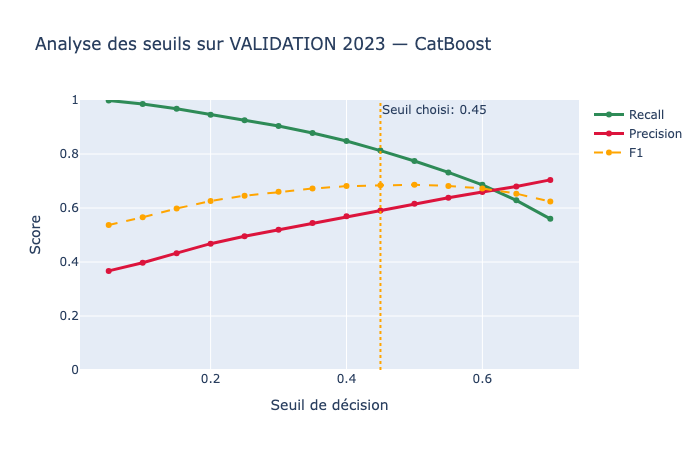


Seuil choisi sur validation : 0.45
  Recall (val)    = 0.813
  Precision (val) = 0.591
  F1 (val)        = 0.684
  Alertes (val)   = 49.4% des accidents

→ Ce seuil sera appliqué au test (2024) pour l'évaluation finale.


In [13]:
# Graphique seuils (sur validation)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_thresh['seuil'], y=df_thresh['recall'], name='Recall', mode='lines+markers', line=dict(color='seagreen', width=3)))
fig.add_trace(go.Scatter(x=df_thresh['seuil'], y=df_thresh['precision'], name='Precision', mode='lines+markers', line=dict(color='crimson', width=3)))
fig.add_trace(go.Scatter(x=df_thresh['seuil'], y=df_thresh['f1'], name='F1', mode='lines+markers', line=dict(color='orange', width=2, dash='dash')))

# Trouver le seuil pour Recall >= 0.80
seuil_opt = df_thresh[df_thresh['recall'] >= 0.80]['seuil'].max()
if pd.notna(seuil_opt):
    fig.add_vline(x=seuil_opt, line_dash='dot', line_color='orange',
                  annotation_text=f'Seuil choisi: {seuil_opt}')

fig.update_layout(
    title=f'Analyse des seuils sur VALIDATION 2023 — {best_model_name}',
    xaxis_title='Seuil de décision', yaxis_title='Score',
    yaxis_range=[0, 1], height=450
)
fig.show()

if pd.notna(seuil_opt):
    row_opt = df_thresh[df_thresh['seuil'] == seuil_opt].iloc[0]
    print(f"\nSeuil choisi sur validation : {seuil_opt}")
    print(f"  Recall (val)    = {row_opt['recall']:.3f}")
    print(f"  Precision (val) = {row_opt['precision']:.3f}")
    print(f"  F1 (val)        = {row_opt['f1']:.3f}")
    print(f"  Alertes (val)   = {row_opt['pct_alertes']:.1f}% des accidents")
    print(f"\n→ Ce seuil sera appliqué au test (2024) pour l'évaluation finale.")
else:
    seuil_opt = 0.5
    print(f"\nRecall >= 0.80 non atteint sur validation, seuil par défaut : {seuil_opt}")

Observation : Le seuil est choisi sur le jeu de validation (2023), pas sur le test (2024). L'objectif est un Recall >= 0.80 pour minimiser les accidents graves non détectés. Ce seuil sera ensuite appliqué tel quel au jeu de test pour obtenir des métriques finales non biaisées.

### Choix du seuil : 0.45

Le seuil par défaut (0.5) ne convient pas ici. On optimise pour le **recall** car dans un contexte de secours, un faux négatif (accident grave non détecté) est plus dangereux qu'un faux positif (alerte inutile).

Seuil retenu : **0.45** → Recall ~81%, Precision ~59%

Concrètement : le modèle détecte 81% des accidents graves, au prix de 41% de fausses alertes. C'est un compromis acceptable pour la priorisation des secours.

---
## 6. Évaluation finale sur le test (2024)

Le seuil a été fixé sur la validation (2023). On applique maintenant ce seuil au jeu de test (2024) pour obtenir les métriques finales. Le modèle est entraîné sur TOUT le training (2021-2023) pour maximiser les données d'apprentissage.

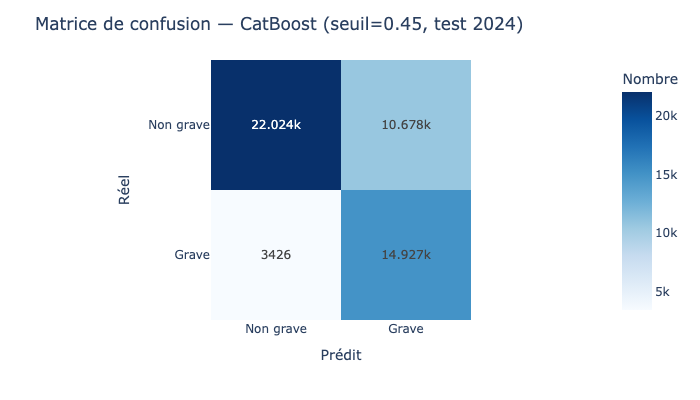

ÉVALUATION FINALE sur test 2024 (seuil=0.45 choisi sur validation 2023)
              precision    recall  f1-score   support

   Non grave       0.87      0.67      0.76     32702
       Grave       0.58      0.81      0.68     18353

    accuracy                           0.72     51055
   macro avg       0.72      0.74      0.72     51055
weighted avg       0.76      0.72      0.73     51055


Résumé au seuil 0.45 (test 2024) :
  ROC-AUC          = 0.817
  Recall           = 0.813  (81.3% des graves détectés)
  Precision        = 0.583  (58.3% des alertes sont vraies)
  F1               = 0.679
  Alertes          = 50.2%
  Faux négatifs    = 18.7% des graves non détectés


In [14]:
# --- Étape 3 : Évaluation finale sur test (2024) ---
# Le meilleur modèle a déjà été entraîné sur 2021-2023 lors du GridSearch
best_model = grid_models[best_model_name]
y_proba_best = grid_probas[best_model_name]

# Appliquer le seuil choisi sur validation
y_pred_opt = (y_proba_best >= seuil_opt).astype(int)

# Matrice de confusion au seuil optimal
cm = confusion_matrix(y_test, y_pred_opt)
labels = ['Non grave', 'Grave']

fig = px.imshow(
    cm, text_auto=True, x=labels, y=labels,
    color_continuous_scale='Blues',
    labels=dict(x='Prédit', y='Réel', color='Nombre')
)
fig.update_layout(title=f'Matrice de confusion — {best_model_name} (seuil={seuil_opt}, test 2024)', height=400)
fig.show()

print(f"ÉVALUATION FINALE sur test 2024 (seuil={seuil_opt} choisi sur validation 2023)")
print(classification_report(y_test, y_pred_opt, target_names=labels))

# Métriques au seuil opérationnel
recall_test = recall_score(y_test, y_pred_opt)
precision_test = precision_score(y_test, y_pred_opt, zero_division=0)
f1_test = f1_score(y_test, y_pred_opt)
auc_test = roc_auc_score(y_test, y_proba_best)
pct_alertes_test = y_pred_opt.sum() / len(y_test) * 100
fn_pct = (cm[1, 0] / cm[1].sum()) * 100

print(f"\nRésumé au seuil {seuil_opt} (test 2024) :")
print(f"  ROC-AUC          = {auc_test:.3f}")
print(f"  Recall           = {recall_test:.3f}  ({recall_test:.1%} des graves détectés)")
print(f"  Precision        = {precision_test:.3f}  ({precision_test:.1%} des alertes sont vraies)")
print(f"  F1               = {f1_test:.3f}")
print(f"  Alertes          = {pct_alertes_test:.1f}%")
print(f"  Faux négatifs    = {fn_pct:.1f}% des graves non détectés")

---
## 7. Diagnostic : Overfitting / Underfitting (Learning Curves)

### Comment savoir si le modèle est au maximum ?

| Diagnostic | Symptôme sur la learning curve | Signification |
|------------|-------------------------------|---------------|
| **Underfitting** | Train ET Test bas, proches | Le modèle est trop simple OU les features ne suffisent pas |
| **Overfitting** | Train très haut, Test bas, écart large | Le modèle a mémorisé le train au lieu de généraliser |
| **Bon fit** | Train un peu au-dessus de Test, les deux convergent | Le modèle généralise correctement |
| **Plafond de features** | Les deux courbes convergent et stagnent | Plus de données ne servirait à rien, il faut de meilleures features |

La learning curve entraîne le modèle sur des sous-ensembles de tailles croissantes et mesure le score sur le train ET sur le test.

  10% ( 15756 acc.) → Train AUC=0.8830  Test AUC=0.8001  Écart=0.0829
  20% ( 31512 acc.) → Train AUC=0.8632  Test AUC=0.8041  Écart=0.0591
  30% ( 47268 acc.) → Train AUC=0.8549  Test AUC=0.8097  Écart=0.0451
  40% ( 63024 acc.) → Train AUC=0.8513  Test AUC=0.8103  Écart=0.0410
  50% ( 78780 acc.) → Train AUC=0.8471  Test AUC=0.8114  Écart=0.0357
  60% ( 94536 acc.) → Train AUC=0.8440  Test AUC=0.8123  Écart=0.0317
  70% (110292 acc.) → Train AUC=0.8421  Test AUC=0.8134  Écart=0.0287
  80% (126048 acc.) → Train AUC=0.8402  Test AUC=0.8147  Écart=0.0256
  90% (141804 acc.) → Train AUC=0.8389  Test AUC=0.8168  Écart=0.0221
  100% (157561 acc.) → Train AUC=0.8382  Test AUC=0.8175  Écart=0.0207


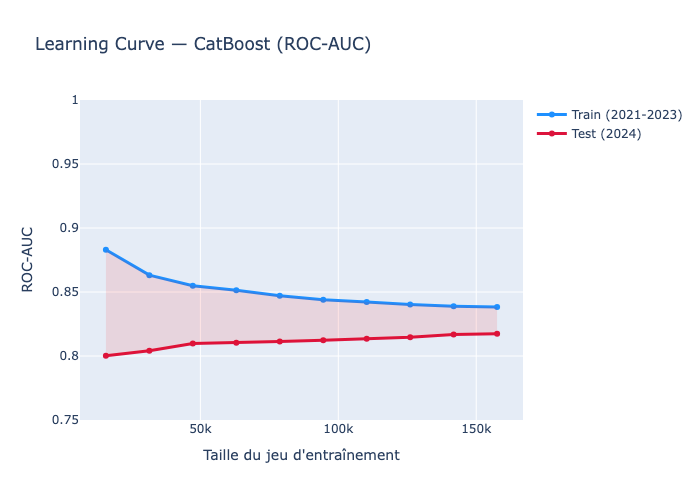


--- DIAGNOSTIC ---
Train AUC (100% données) : 0.8382
Test AUC  (2024)         : 0.8175
Écart train-test         : 0.0207

→ Écart entre 0.02 et 0.05 : léger overfitting, acceptable.
  Le modèle a légèrement mémorisé le train mais reste raisonnable.

→ La courbe test monte encore légèrement : plus de données pourrait aider.


In [15]:
# --- Learning Curve : le modèle overfitte-t-il ? ---
# On entraîne le meilleur modèle sur des sous-ensembles croissants du train (chronologiques)
# et on mesure le score sur le train ET sur le test (2024).

fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lc_train_scores = []
lc_test_scores = []
lc_sizes = []

cat_idx_lc = [i for i, c in enumerate(X_train.columns) if c == 'dep']

for frac in fractions:
    n = int(len(X_train) * frac)
    X_sub = X_train.iloc[:n]  # Premiers n échantillons (ordre chronologique)
    y_sub = y_train.iloc[:n]
    
    # Créer un modèle frais avec les mêmes hyperparamètres
    if best_model_name == 'CatBoost':
        lc_model = CatBoostClassifier(
            **{k: v for k, v in grid_models['CatBoost'].get_all_params().items()
               if k in ['iterations', 'depth', 'learning_rate']},
            auto_class_weights='Balanced', random_state=42, verbose=False
        )
        lc_model.fit(X_sub, y_sub, cat_features=cat_idx_lc)
    elif best_model_name == 'LightGBM':
        lc_model = LGBMClassifier(**grid_models['LightGBM'].get_params())
        lc_model.fit(X_sub, y_sub)
    else:
        lc_model = XGBClassifier(**grid_models['XGBoost'].get_params())
        lc_model.fit(X_sub, y_sub)
    
    # Score sur le train (sous-ensemble)
    train_proba = lc_model.predict_proba(X_sub)[:, 1]
    train_auc = roc_auc_score(y_sub, train_proba)
    
    # Score sur le test (toujours 2024)
    test_proba = lc_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_proba)
    
    lc_sizes.append(n)
    lc_train_scores.append(train_auc)
    lc_test_scores.append(test_auc)
    
    print(f"  {frac:.0%} ({n:>6d} acc.) → Train AUC={train_auc:.4f}  Test AUC={test_auc:.4f}  Écart={train_auc - test_auc:.4f}")

# --- Graphique Learning Curve ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=lc_sizes, y=lc_train_scores,
    name='Train (2021-2023)', mode='lines+markers',
    line=dict(color='dodgerblue', width=3)
))
fig.add_trace(go.Scatter(
    x=lc_sizes, y=lc_test_scores,
    name='Test (2024)', mode='lines+markers',
    line=dict(color='crimson', width=3)
))

# Zone d'écart (overfitting)
fig.add_trace(go.Scatter(
    x=lc_sizes + lc_sizes[::-1],
    y=lc_train_scores + lc_test_scores[::-1],
    fill='toself', fillcolor='rgba(255,0,0,0.1)',
    line=dict(width=0), showlegend=False,
    name='Écart train-test'
))

fig.update_layout(
    title=f'Learning Curve — {best_model_name} (ROC-AUC)',
    xaxis_title='Taille du jeu d\'entraînement',
    yaxis_title='ROC-AUC',
    height=500,
    yaxis_range=[0.75, 1.0]
)
fig.show()

# --- Diagnostic ---
gap = lc_train_scores[-1] - lc_test_scores[-1]
print(f"\n--- DIAGNOSTIC ---")
print(f"Train AUC (100% données) : {lc_train_scores[-1]:.4f}")
print(f"Test AUC  (2024)         : {lc_test_scores[-1]:.4f}")
print(f"Écart train-test         : {gap:.4f}")

if gap < 0.02:
    print(f"\n→ Écart < 0.02 : PAS d'overfitting significatif.")
    print(f"  Les courbes sont proches = le modèle généralise bien.")
    print(f"  Si les deux scores plafonnent, c'est un plafond de FEATURES (pas de données).")
elif gap < 0.05:
    print(f"\n→ Écart entre 0.02 et 0.05 : léger overfitting, acceptable.")
    print(f"  Le modèle a légèrement mémorisé le train mais reste raisonnable.")
else:
    print(f"\n→ Écart > 0.05 : overfitting significatif.")
    print(f"  Pistes : réduire max_depth, augmenter la régularisation, ou simplifier les features.")

# La courbe test monte-t-elle encore ?
last_3_test = lc_test_scores[-3:]
if last_3_test[-1] - last_3_test[0] < 0.002:
    print(f"\n→ La courbe test stagne : plus de données ne changerait rien.")
    print(f"  Pour aller au-delà de ~{lc_test_scores[-1]:.3f}, il faut de MEILLEURES FEATURES.")
else:
    print(f"\n→ La courbe test monte encore légèrement : plus de données pourrait aider.")

---
## 8. Analyse des erreurs

Qui sont les accidents graves que le modèle rate (faux négatifs) ? Comprendre leur profil permet d'identifier les limites du modèle et les pistes d'amélioration.

In [16]:
# Faux négatifs : profil des accidents graves ratés
X_test_r = X_test.reset_index(drop=True)
y_test_r = y_test.reset_index(drop=True)
y_pred_r = pd.Series(y_pred_opt)

fn_mask = (y_test_r == 1) & (y_pred_r == 0)
tp_mask = (y_test_r == 1) & (y_pred_r == 1)

fn = X_test_r[fn_mask]
tp = X_test_r[tp_mask]

print(f"Faux Négatifs : {fn.shape[0]} ({fn.shape[0] / (y_test_r == 1).sum():.1%} des graves)")
print(f"Vrais Positifs : {tp.shape[0]}")

if fn.shape[0] > 0 and tp.shape[0] > 0:
    # Exclure dep (label encoding, la moyenne n'a pas de sens pour une catégorielle)
    cols_comparables = [c for c in fn.columns if c != 'dep']
    
    diff = pd.DataFrame({
        'FN_mean': fn[cols_comparables].mean(),
        'TP_mean': tp[cols_comparables].mean(),
        'diff': tp[cols_comparables].mean() - fn[cols_comparables].mean()
    }).sort_values('diff', key=abs, ascending=False)
    
    print("\nTop 10 différences FN vs TP :")
    print(diff.head(10).round(3).to_string())

Faux Négatifs : 3426 (18.7% des graves)
Vrais Positifs : 14927

Top 10 différences FN vs TP :
                       FN_mean  TP_mean    diff
vma                     50.884   68.974  18.090
hors_agglo               0.158    0.623   0.465
route_departementale     0.187    0.636   0.449
route_communale          0.615    0.220  -0.395
heure                   13.608   13.286  -0.322
bidirectionnelle         0.489    0.802   0.312
nbv                      2.261    2.046  -0.214
nb_vehicules             1.730    1.559  -0.171
intersection_complexe    0.388    0.229  -0.158
collision_cote           0.350    0.202  -0.148


Observation : Les faux négatifs (accidents graves non détectés) ont un profil distinct : accidents **en agglomération**, sur **routes communales**, avec **faible VMA** et **peu de voies**. Ce sont des accidents urbains qui semblent "bénins" (basse vitesse, route simple) mais qui causent des blessures graves, typiquement des piétons ou cyclistes percutés en ville. Le modèle a du mal à les distinguer car les indicateurs habituels de gravité (hors agglo, grande vitesse, route bidirectionnelle) sont absents.

**Piste d'amélioration** : Ajouter des informations sur les usagers vulnérables (piétons, vélos) détectés au moment de l'appel pourrait aider à capturer ces cas.

---
## 9. Feature Importance (split count + gain)

### Deux méthodes complémentaires

| Méthode | Mesure | Biais connu |
|---------|--------|-------------|
| Split count | Nombre de fois qu'une feature est utilisée pour un split | Favorise les features à haute cardinalité (dep, heure) |
| Gain | Réduction moyenne de l'erreur quand la feature est utilisée | Plus fiable, mesure l'impact réel |

> **Note** : SHAP (SHapley Additive exPlanations) peut compléter cette analyse si installé (`pip install shap`). Il calcule la contribution marginale de chaque feature pour chaque prédiction, ce qui en fait la méthode la plus fiable mais aussi la plus lente.

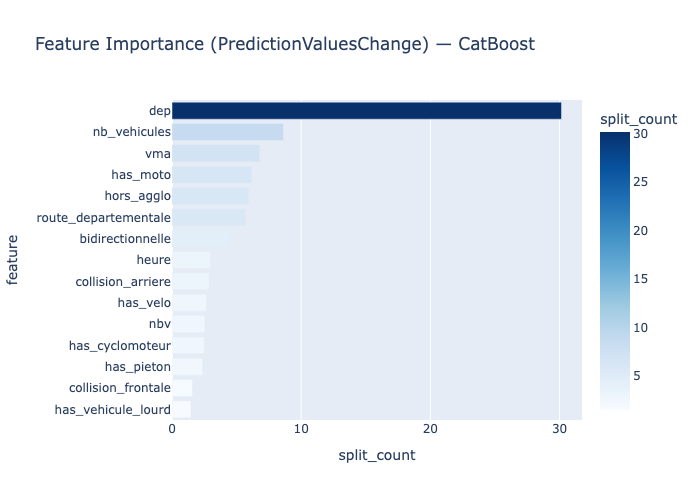

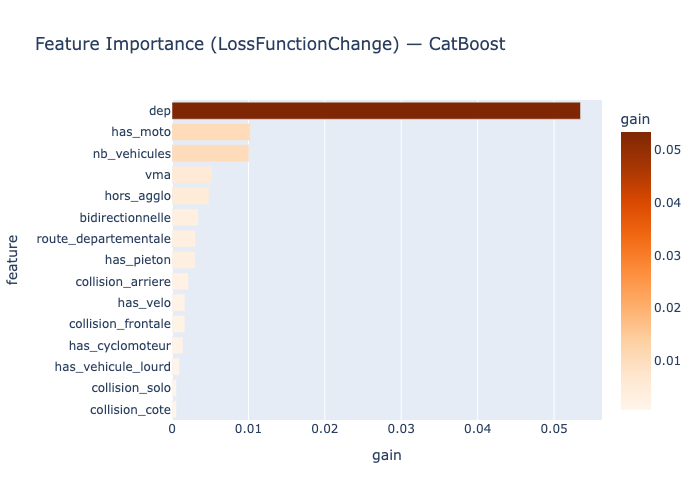

Comparaison PredictionValuesChange vs LossFunctionChange (top 15 par LossFunctionChange) :
             feature  split_count  rank_split     gain  rank_gain  diff_rank
                 dep    30.151360           1 0.053458          1          0
            has_moto     6.169086           4 0.010254          2          2
        nb_vehicules     8.633483           2 0.010065          3         -1
                 vma     6.785886           3 0.005224          4         -1
          hors_agglo     5.945252           5 0.004868          5          0
    bidirectionnelle     4.449500           7 0.003430          6          1
route_departementale     5.716370           6 0.003072          7         -1
          has_pieton     2.383077          13 0.003039          8          5
   collision_arriere     2.861749           9 0.002168          9          0
            has_velo     2.671198          10 0.001711         10          0
  collision_frontale     1.573205          14 0.001668        

In [17]:
# --- 1. Feature importance par split count / défaut ---
if hasattr(best_model, 'feature_importances_'):
    importances_split = best_model.feature_importances_
elif hasattr(best_model, 'get_feature_importance'):
    importances_split = best_model.get_feature_importance()
else:
    importances_split = None

# --- 2. Feature importance par GAIN (plus fiable) ---
importances_gain = None
if best_model_name == 'LightGBM' and hasattr(best_model, 'booster_'):
    importances_gain = best_model.booster_.feature_importance(importance_type='gain')
elif best_model_name == 'XGBoost' and hasattr(best_model, 'get_booster'):
    booster = best_model.get_booster()
    gain_dict = booster.get_score(importance_type='gain')
    importances_gain = np.array([gain_dict.get(f, 0) for f in X_train.columns])
elif best_model_name == 'CatBoost' and hasattr(best_model, 'get_feature_importance'):
    # CatBoost : LossFunctionChange = équivalent du "gain" (réduction de la loss)
    # Nécessite de passer les données pour le calcul
    test_pool = Pool(X_test, y_test, cat_features=[i for i, c in enumerate(X_test.columns) if c == 'dep'])
    importances_gain = best_model.get_feature_importance(data=test_pool, type='LossFunctionChange')

# Affichage côte à côte : split count vs gain
if importances_split is not None and importances_gain is not None:
    fi_df = pd.DataFrame({
        'feature': X_train.columns,
        'split_count': importances_split,
        'gain': importances_gain
    })
    
    # Noms adaptés selon le modèle
    split_label = 'PredictionValuesChange' if best_model_name == 'CatBoost' else 'Split count'
    gain_label = 'LossFunctionChange' if best_model_name == 'CatBoost' else 'Gain'
    
    # Plot split count (top 15)
    fi_split = fi_df.sort_values('split_count', ascending=True).tail(15)
    fig1 = px.bar(fi_split, x='split_count', y='feature', orientation='h',
                  title=f'Feature Importance ({split_label}) — {best_model_name}',
                  color='split_count', color_continuous_scale='Blues')
    fig1.update_layout(height=500, showlegend=False)
    fig1.show()
    
    # Plot gain (top 15)
    fi_gain = fi_df.sort_values('gain', ascending=True).tail(15)
    fig2 = px.bar(fi_gain, x='gain', y='feature', orientation='h',
                  title=f'Feature Importance ({gain_label}) — {best_model_name}',
                  color='gain', color_continuous_scale='Oranges')
    fig2.update_layout(height=500, showlegend=False)
    fig2.show()
    
    # Comparaison des classements
    fi_df['rank_split'] = fi_df['split_count'].rank(ascending=False).astype(int)
    fi_df['rank_gain'] = fi_df['gain'].rank(ascending=False).astype(int)
    fi_df['diff_rank'] = fi_df['rank_split'] - fi_df['rank_gain']
    
    print(f"Comparaison {split_label} vs {gain_label} (top 15 par {gain_label}) :")
    top_by_gain = fi_df.sort_values('gain', ascending=False).head(15)
    print(top_by_gain[['feature', 'split_count', 'rank_split', 'gain', 'rank_gain', 'diff_rank']].to_string(index=False))
elif importances_split is not None:
    fi_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances_split
    }).sort_values('importance', ascending=True).tail(15)
    
    fig = px.bar(fi_df, x='importance', y='feature', orientation='h',
                 title=f'Top 15 Feature Importance — {best_model_name}',
                 color='importance', color_continuous_scale='Blues')
    fig.update_layout(height=500, showlegend=False)
    fig.show()

Observation : La comparaison split count vs gain révèle des différences importantes. Le split count favorise mécaniquement les features à haute cardinalité (dep, heure, mois) car chaque valeur offre un seuil de split possible. Le gain mesure la réduction réelle de l'erreur : les features comme hors_agglo, collision_frontale ou vma ont un impact plus fort par split. **Le gain est la mesure la plus fiable** pour comprendre quelles features le modèle utilise vraiment.

In [18]:
# --- 3. SHAP (SHapley Additive exPlanations) ---
# SHAP calcule la contribution de chaque feature pour CHAQUE prédiction.
# C'est la méthode la plus fiable et la plus interprétable.
if SHAP_AVAILABLE:
    print("Calcul SHAP (peut prendre quelques minutes)...")
    
    # Échantillon pour SHAP (le calcul exact est coûteux)
    shap_sample_size = min(5000, len(X_test))
    X_shap = X_test.sample(n=shap_sample_size, random_state=42)
    
    if best_model_name == 'LightGBM':
        explainer = shap.TreeExplainer(best_model)
    elif best_model_name == 'XGBoost':
        explainer = shap.TreeExplainer(best_model)
    else:
        explainer = shap.TreeExplainer(best_model)
    
    shap_values = explainer.shap_values(X_shap)
    
    # Si c'est une liste (binary classification), prendre les valeurs pour la classe positive
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values
    
    # Summary plot (barplot des importances moyennes SHAP)
    print("\nSHAP Summary (importance moyenne) :")
    shap_importance = pd.DataFrame({
        'feature': X_shap.columns,
        'mean_abs_shap': np.abs(shap_vals).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False)
    
    print(shap_importance.head(15).to_string(index=False))
    
    # Beeswarm plot
    fig_shap = shap.summary_plot(shap_vals, X_shap, show=False, max_display=20)
    import matplotlib.pyplot as plt
    plt.title(f'SHAP Values — {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print(f"\nSHAP calculé sur {shap_sample_size} accidents du test (2024)")
else:
    print("SHAP non disponible. Pour l'installer : pip install shap")

SHAP non disponible. Pour l'installer : pip install shap


---
## 10. Sauvegarde du modèle final

In [19]:
# Sauvegarder le modèle
model_path = MODELS_DIR / 'model_UC1_final.joblib'
joblib.dump(best_model, model_path)
print(f"Modèle sauvegardé : {model_path}")

# Métadonnées complètes avec métriques aux DEUX seuils
metadata = {
    'features': list(X_train.columns.tolist()),
    'target': TARGET,
    'model_type': best_model_name,
    'best_params': df_grid.loc[best_idx, 'best_params'],
    'cv_method': 'TimeSeriesSplit(n_splits=3)',
    'split': 'Temporel: Train 2021-2023, Test 2024',
    'threshold_selection': 'Validation 2023 (train 2021-2022, val 2023)',
    'operational_threshold': float(seuil_opt),
    'metrics_at_default_threshold_0.5': {
        'roc_auc': float(df_grid.loc[best_idx, 'roc_auc']),
        'recall': float(df_grid.loc[best_idx, 'recall']),
        'precision': float(df_grid.loc[best_idx, 'precision']),
        'f1': float(df_grid.loc[best_idx, 'f1']),
    },
    'metrics_at_operational_threshold': {
        'threshold': float(seuil_opt),
        'recall': float(recall_test),
        'precision': float(precision_test),
        'f1': float(f1_test),
        'roc_auc': float(auc_test),
        'pct_alertes': float(pct_alertes_test),
    },
}

meta_path = MODELS_DIR / 'metadata_UC1.json'
with open(meta_path, 'w') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Métadonnées sauvegardées : {meta_path}")
print(f"\nContenu :")
print(json.dumps(metadata, indent=2, ensure_ascii=False))

Modèle sauvegardé : ../../models/model_UC1_final.joblib
Métadonnées sauvegardées : ../../models/metadata_UC1.json

Contenu :
{
  "features": [
    "dep",
    "heure",
    "mois",
    "weekend",
    "nuit",
    "heure_pointe",
    "heure_danger",
    "nuit_eclairee",
    "vma",
    "nbv",
    "hors_agglo",
    "bidirectionnelle",
    "haute_vitesse",
    "meteo_degradee",
    "surface_glissante",
    "intersection_complexe",
    "route_en_pente",
    "route_autoroute",
    "route_departementale",
    "route_communale",
    "nuit_hors_agglo",
    "weekend_nuit",
    "has_moto",
    "has_velo",
    "has_edp",
    "has_cyclomoteur",
    "has_pieton",
    "has_vehicule_lourd",
    "collision_asymetrique",
    "nb_vehicules",
    "collision_frontale",
    "collision_arriere",
    "collision_cote",
    "collision_solo",
    "frontale_x_hors_agglo",
    "vitesse_x_bidirect",
    "moto_x_hors_agglo"
  ],
  "target": "grave",
  "model_type": "CatBoost",
  "best_params": "{'depth': 6, 'learning_r

---
## 11. Modèles multi-niveaux pour le déploiement API

Pour l'API, on entraîne un CatBoost par niveau d'information disponible lors de l'appel :

| Modèle | Features | Scénario |
|--------|----------|----------|
| V1 (8 features) | Lieu, heure, luminosité | "On sait juste quand et où" |
| V2 (23 features) | + route, météo, surface | "On connaît les conditions de route" |
| V3 (32 features) | + véhicules impliqués | "On sait quels véhicules sont impliqués" |
| V4 (37 features) | + type de collision | "On connaît le type de choc" |

Mêmes hyperparamètres CatBoost (depth=6, lr=0.1, iterations=300). L'API sélectionne automatiquement le modèle adapté au niveau d'information fourni par l'opérateur.

In [20]:
# --- Entraînement multi-niveaux ---
print("Entraînement de 4 modèles CatBoost pour le déploiement API")
print("=" * 60)

best_params_deploy = {'depth': 6, 'learning_rate': 0.1, 'iterations': 300}

api_metadata = {
    'models': {},
    'dep_mapping': {str(k): int(v) for k, v in dep_mapping.items()},
    'threshold': float(seuil_opt),
    'target': TARGET,
}

for version, df_v in datasets.items():
    X_tr, X_te, y_tr, y_te = temporal_split(df_v, TARGET, META_COLS)
    
    # Trier par année pour cohérence
    train_years = df_v.loc[df_v['annee'] <= 2023, 'annee']
    sort_idx = train_years.sort_values().index
    X_tr = X_tr.loc[sort_idx].reset_index(drop=True)
    y_tr = y_tr.loc[sort_idx].reset_index(drop=True)
    
    cat_idx_v = [i for i, c in enumerate(X_tr.columns) if c == 'dep']
    features = X_tr.columns.tolist()
    
    model_v = CatBoostClassifier(
        **best_params_deploy,
        auto_class_weights='Balanced',
        random_state=42,
        verbose=False
    )
    model_v.fit(X_tr, y_tr, cat_features=cat_idx_v)
    
    # Évaluation sur test 2024
    y_proba_v = model_v.predict_proba(X_te)[:, 1]
    auc_v = roc_auc_score(y_te, y_proba_v)
    y_pred_v = (y_proba_v >= seuil_opt).astype(int)
    recall_v = recall_score(y_te, y_pred_v)
    precision_v = precision_score(y_te, y_pred_v, zero_division=0)
    f1_v = f1_score(y_te, y_pred_v)
    
    # Sauvegarder
    model_path_v = MODELS_DIR / f'model_UC1_{version}.joblib'
    joblib.dump(model_v, model_path_v)
    
    api_metadata['models'][version] = {
        'features': features,
        'n_features': len(features),
        'model_path': f'model_UC1_{version}.joblib',
        'metrics_test_2024': {
            'roc_auc': round(float(auc_v), 4),
            'recall_at_threshold': round(float(recall_v), 4),
            'precision_at_threshold': round(float(precision_v), 4),
            'f1_at_threshold': round(float(f1_v), 4),
        }
    }
    
    print(f"\n{version} ({len(features)} features) :")
    print(f"  ROC-AUC          = {auc_v:.3f}")
    print(f"  Recall (seuil {seuil_opt}) = {recall_v:.3f}")
    print(f"  Precision        = {precision_v:.3f}")
    print(f"  Sauvegarde : {model_path_v}")

# Sauvegarder les métadonnées pour l'API
api_meta_path = MODELS_DIR / 'metadata_UC1_api.json'
with open(api_meta_path, 'w') as f:
    json.dump(api_metadata, f, indent=2, ensure_ascii=False)

# Sauvegarder le dep_mapping séparément
dep_path = MODELS_DIR / 'dep_mapping.json'
with open(dep_path, 'w') as f:
    json.dump({str(k): int(v) for k, v in dep_mapping.items()}, f, indent=2)

print(f"\n{'=' * 60}")
print(f"Fichiers sauvegardés dans {MODELS_DIR}/ :")
print(f"  4 modèles : model_UC1_v1_base.joblib ... model_UC1_v4_collision.joblib")
print(f"  Métadonnées API : metadata_UC1_api.json")
print(f"  Mapping départements : dep_mapping.json")

Entraînement de 4 modèles CatBoost pour le déploiement API

v1_base (8 features) :
  ROC-AUC          = 0.737
  Recall (seuil 0.45) = 0.809
  Precision        = 0.497
  Sauvegarde : ../../models/model_UC1_v1_base.joblib

v2_route (23 features) :
  ROC-AUC          = 0.790
  Recall (seuil 0.45) = 0.787
  Precision        = 0.561
  Sauvegarde : ../../models/model_UC1_v2_route.joblib

v3_vehicules (32 features) :
  ROC-AUC          = 0.812
  Recall (seuil 0.45) = 0.810
  Precision        = 0.577
  Sauvegarde : ../../models/model_UC1_v3_vehicules.joblib

v4_collision (37 features) :
  ROC-AUC          = 0.817
  Recall (seuil 0.45) = 0.813
  Precision        = 0.583
  Sauvegarde : ../../models/model_UC1_v4_collision.joblib

Fichiers sauvegardés dans ../../models/ :
  4 modèles : model_UC1_v1_base.joblib ... model_UC1_v4_collision.joblib
  Métadonnées API : metadata_UC1_api.json
  Mapping départements : dep_mapping.json


---
## 12. Résumé final

## Conclusion

### Ce que fait le modèle

Un appel d'urgence arrive : "Accident sur la D47, hors agglomération, deux véhicules dont une moto, de nuit." Le modèle prend ces informations, calcule une probabilité de gravité, et si elle dépasse le seuil, alerte les secours pour envoyer des moyens renforcés.

### Améliorations méthodologiques v3

| Amélioration | Avant | Après | Pourquoi |
|-------------|-------|-------|----------|
| Validation croisée | StratifiedKFold (mélange les années) | TimeSeriesSplit (respecte la chronologie) | Évite la fuite temporelle |
| Encodage dep | pd.factorize (entiers ordonnés) | dtype category (catégoriel natif) | Permet des regroupements libres de départements |
| Sélection du seuil | Sur le test (2024) | Sur la validation (2023) | Le test reste indépendant |
| Feature importance | Split count seulement | Split count + Gain (SHAP optionnel) | Interprétation plus fiable |
| Métadonnées | Métriques au seuil 0.5 uniquement | Métriques aux deux seuils | Cohérence avec le seuil opérationnel |
| Interactions | Aucune | 3 interactions explicites | Facilite l'apprentissage |

### Choix de la target

Le choix de `grave` (35.4%) plutôt que `mortel` (5.7%) :

1. **Utilité opérationnelle** : Un blessé grave bénéficie d'une intervention rapide. Un décédé, non.
2. **Meilleur équilibre** : Ratio 1:1.8 (pas besoin de SMOTE) vs 1:16.6
3. **Inclusion** : 100% des mortels sont inclus dans grave

### Limites connues

- **Faux négatifs urbains** : Le modèle rate ~18% des accidents graves, surtout en ville (piétons/cyclistes percutés à basse vitesse)
- **Features limitées** : En temps réel, on n'a que les informations de l'appel, pas les détails post-accident
- **Stabilité temporelle** : Les performances pourraient varier si les patterns d'accidents changent

### Recommandation opérationnelle

Utiliser le seuil choisi sur validation en production. Les secours recevront des alertes prioritaires pour environ la moitié des accidents, dont ~80% seront effectivement graves.